In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
from numpy import median,mean
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from random import randint

## NLP Class
This is a custom made class I made that holds all the algorithms, modules and functions I am planning to use in analyzing the text data. I chose to wrap it all in a class for reasons of convenience, scalability and ease of use.

In [2]:
class nlp:
    #need to download from nltk - 'averaged_perceptron_tagger','wordnet','stopwords'
    re = __import__('re')
    pd = __import__('pandas')
    nltk = __import__('nltk')
    np = __import__('numpy')
    
    def __init__(self):
        print('nlp V.0.1 \nImported pandas,re,nltk,numpy packages')
        
    def clean_text_for_topic_modelling(self,text_column):
        text_column=text_column.str.lower()
        text_column = [self.re.sub(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b','', x) for x in text_column]
        text_column = [x.split() for x in text_column]
        temp_corpus=[]
        for tweet in text_column:
            new_list=[w for w in tweet if len(w)>2]
            temp_corpus.append(new_list)
        return self.pd.Series(temp_corpus)
    
    def remove_stopwords_from_corpus(self,text_column,extra_stopwords_list=[]):
        from nltk.corpus import stopwords
        stops = set(stopwords.words('english')).union(extra_stopwords_list)
        text_column=text_column.apply(lambda x: [w for w in x if w not in stops])
        return text_column
    
    def stemm_corpus(self,text_column,stemmer='porter'):
        if stemmer=='porter':
            from nltk.stem import PorterStemmer
            porter = PorterStemmer()
            text_column=text_column.apply(lambda x:[porter.stem(w) for w in x])
        elif stemmer=='lancaster':
            from nltk.stem import LancasterStemmer
            lancaster=LancasterStemmer()
            text_column=text_column.apply(lambda x:[lancaster.stem(w) for w in x])
        else:
            from nltk.stem import SnowballStemmer
            snowball=SnowballStemmer("english")
            text_column=text_column.apply(lambda x:[snowball.stem(w) for w in x])
        return text_column
    
    def lemmatize_corpus(self,text_column):
        from nltk.stem import WordNetLemmatizer
        from nltk.corpus import wordnet
        
        def get_word_pos(word):
            tag = self.nltk.pos_tag(word)[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
            return tag_dict.get(tag, wordnet.NOUN)
        
        wordnet_lemmatizer = WordNetLemmatizer()
        text_column=text_column.apply(lambda x:[wordnet_lemmatizer.lemmatize(w, pos=get_word_pos(w)) for w in x])
        return text_column
    
    def create_ngrams(self,text_column,replace=False,num_grams=2):
        from nltk import ngrams
        if replace:
            grams_list=[]
            for tweet in text_column:
                grams_list.append([' '.join(ngram) for ngram in ngrams(tweet,num_grams)])
            return self.pd.Series(grams_list)
        else:
            for i,tweet in text_column.iteritems():
                copy_tweet=tweet.copy()
                for ngram in ngrams(tweet,2):
                    copy_tweet.append(' '.join(ngram))
                text_column.at[i]=copy_tweet
            return text_column
        
    def gensim_dic(self,text_column,filter_extremes=True,no_below=3,no_above=0.99):
        from gensim.corpora import Dictionary
        dictionary=Dictionary(text_column)
        if filter_extremes:
            dictionary.filter_extremes(no_below=no_below, no_above=no_above)
        return dictionary
    
    def bow_corpus(self,dictionary,text_column):
        return [dictionary.doc2bow(doc) for doc in text_column]
    
    def one_hot_encoding_todf(self,dictionary,text_column):
        from tqdm import tqdm
        columns=[dictionary.get(i) for i in range(len(dictionary))]
        one_hot_df=pd.DataFrame(columns=columns)
        for i,row in tqdm(enumerate(train.comment_text)):
            for word in row:
                one_hot_df.at[i,word]=+1
        return one_hot_df
    
    def tf_idf_tomatrix(self,dictionary,tf_idf_object):
        from gensim.matutils import corpus2dense
        num_terms = len(dictionary.keys())
        num_docs = dictionary.num_docs
        corpus_tfidf_dense = corpus2dense(tf_idf_object, num_terms, num_docs)
        return self.pd.DataFrame(self.np.transpose(corpus_tfidf_dense))
        
    def vec_to_tfidf(self,bow_corpus):
        from gensim import models
        tfidf = models.TfidfModel(bow_corpus)
        return tfidf[bow_corpus]
    
    def lda_model(self,tfidf_corp,dic,num_topics=20,passes=30,alpha=0.001,eta='auto'):
        from gensim import models
        return models.ldamodel.LdaModel(corpus=tfidf_corp, num_topics=num_topics, id2word=dic, passes=passes, alpha=alpha, 
                                             eta=eta,random_state=13)
    
    def get_coherence(self,lda_model,corpus,dic):
        from gensim.models import CoherenceModel
        coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=dic, coherence='c_v')
        return coherence_model_lda.get_coherence()
    
    def assign_lda_topic(self,lda_model,bow_corpus):
        topics=[]
        data=lda_model.get_document_topics(bow_corpus)
        for tweet in data:  
            df = self.pd.DataFrame(tweet, columns=['topic_num', 'probability'])
            topics.append(df.loc[df['probability'].idxmax(), 'topic_num'])
        return (self.pd.Series(topics))
    
    def get_sentiment(self,text_column):
        from textblob import TextBlob
        return text_column.apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
    
    def get_length_of_comment(self,text_column):
        return text_column.apply(lambda x: len(x))
    
    def amount_of_upper(self,text_column):
        return text_column.apply(lambda x: sum(1 for c in x if c.isupper()))
    
    def create_uppercase_max_sequence_column(self,text_column):
        def get_max_uppercase_run_from_string(s):
            lengths=[len(x) for x in self.re.findall(r"[A-Z]+", s)]
            if len(lengths)>0:
                return max(lengths)
            else:
                return 0
        return (text_column.apply(lambda x: get_max_uppercase_run_from_string(x)))
    
    def amount_of_sign(self,text_column,sign):
        return text_column.apply(lambda x: sum(1 for c in x if c==sign))
    
    def max_sequence(self,text_column,symbol):
        def get_max_sequence_run_from_string(s,symbol):
            lengths=[len(x) for x in self.re.findall(r"["+symbol+"]+", s)]
            if len(lengths)>0:
                return max(lengths)
            else:
                return 0   
        return text_column.apply(lambda x: get_max_sequence_run_from_string(x,symbol))
    
    def remove_punctuation(self,text_column):
        import string
        return text_column.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    
    def bad_comments_column_bin(self,text_column,bad_words_list):
        def is_comment_bad(comment,bad_words_list):
            for word in comment:
                if word in bad_words_list:
                    return 1
            return 0
        return text_column.apply(lambda x: is_comment_bad(x,bad_words_list))

    def bad_comments_column_agg(self,text_column,bad_words_list):
        def amount_comment_bad_words(comment,bad_words_list):
            count_of_bad_words=0
            for word in comment:
                if word in bad_words_list:
                    count_of_bad_words=count_of_bad_words+1
            return count_of_bad_words
        return text_column.apply(lambda x: amount_comment_bad_words(x,bad_words_list))

## Preparing the dataset
Load data and replace \n skip row sign with whitespace

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train=train.replace('\n',' ')
test=test.replace('\n',' ')

1.	Create class object nlp that holds all the NLP algorithms and methods.
2.	Create empty dataframe X that will hold all of the features.
3.	Seperate the two target variables from the training dataframe.

In [4]:
nlp=nlp()
X=pd.DataFrame()
y_toxic=train['toxic'].copy()
y_obscene=train['obscene'].copy()

nlp V.0.1 
Imported pandas,re,nltk,numpy packages


Create text corpus from train and test set together. All the relevant NLP methods will be done on both sets. In the end I'll seperate them again for training the model and creating predictions.

In [5]:
train_test_text=train.comment_text.append(test.comment_text,ignore_index=True)

# Exploratory Data Analysis and Feature Selection
## Comment length
By inspecting the length of comments grouped by the target variables groups we can see that it looks like toxic and obscene comments are usually shorter.

C:\Users\natan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


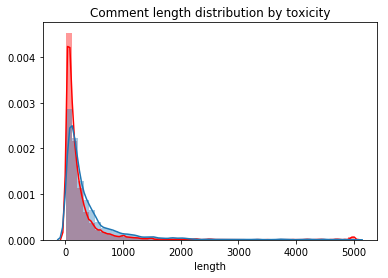

In [6]:
X['length']=nlp.get_length_of_comment(train_test_text)
inspect=pd.DataFrame(X['length']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.distplot(inspect.loc[inspect['toxic']==1,'length'],color="r").set_title('Comment length distribution by toxicity')
sns.distplot(inspect.loc[inspect['toxic']==0,'length'])

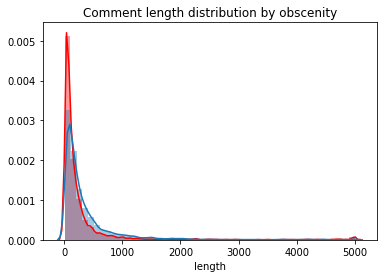

In [7]:
sns.distplot(inspect.loc[inspect['obscene']==1,'length'],color="r").set_title('Comment length distribution by obscenity')
sns.distplot(inspect.loc[inspect['obscene']==0,'length'])

## Amount of upper case letters
Inspecting the median upper case letters amount we can see that toxic and obscene comments have less upper case letters. I chose the median estimator to make the estimation more robust to outliers.

Text(0.5, 1.0, 'Comment amount of upper case letters by toxicity')

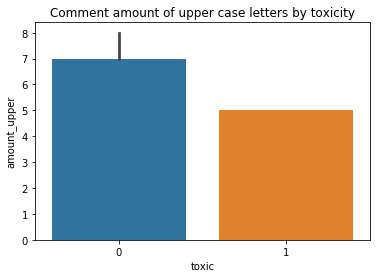

In [8]:
X['amount_upper']=nlp.amount_of_upper(train_test_text)
inspect=pd.DataFrame(X['amount_upper']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="amount_upper", data=inspect, estimator=median).set_title('Comment amount of upper case letters by toxicity')

Text(0.5, 1.0, 'Comment amount of upper case letters by obscenity')

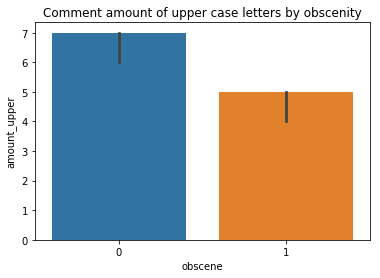

In [9]:
sns.barplot(x="obscene", y="amount_upper", data=inspect, estimator=median).set_title('Comment amount of upper case letters by obscenity')

## Maximum sequence of upper case letters
We can see that for both toxicity and obscenity, the average maximum sequence of upper case letters is higher.

Text(0.5, 1.0, 'Comment max upper case letters sequence by toxicity')

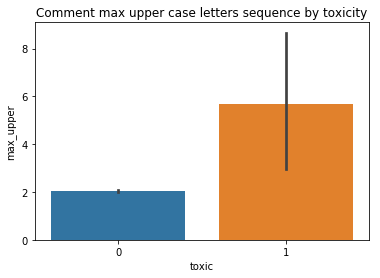

In [10]:
X['max_upper']=nlp.create_uppercase_max_sequence_column(train_test_text)
inspect=pd.DataFrame(X['max_upper']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="max_upper", data=inspect, estimator=mean).set_title('Comment max upper case letters sequence by toxicity')

Text(0.5, 1.0, 'Comment max upper case letters sequence by obscenity')

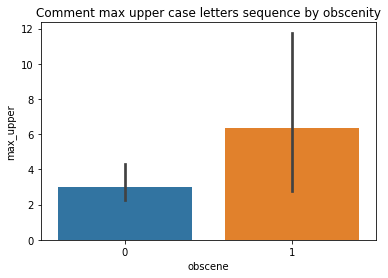

In [11]:
sns.barplot(x="obscene", y="max_upper", data=inspect, estimator=mean).set_title('Comment max upper case letters sequence by obscenity')

## Comment sentiment
Toxic and obscene comments tend to have less positive sentiment score

Text(0.5, 1.0, 'Comment average sentiment by toxicity')

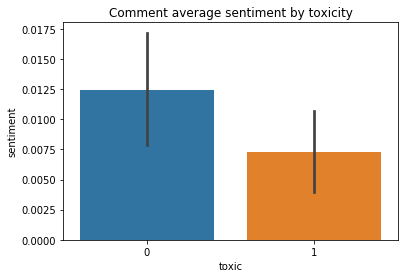

In [12]:
X['sentiment']=nlp.get_sentiment(train_test_text)
inspect=pd.DataFrame(X['sentiment']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="sentiment", data=inspect, estimator=mean).set_title('Comment average sentiment by toxicity')

Text(0.5, 1.0, 'Comment average sentiment by obscenity')

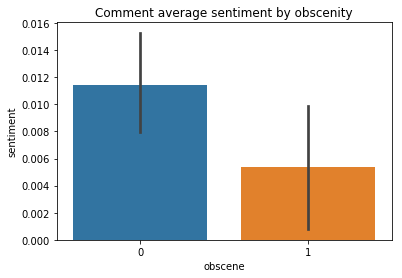

In [13]:
sns.barplot(x="obscene", y="sentiment", data=inspect, estimator=mean).set_title('Comment average sentiment by obscenity')

## Comment amount of question marks
Toxic comments have more question marks. Obscene comments don't have more question marks than non-obscene comments.

Text(0.5, 1.0, 'Comment amount of question marks by toxicity')

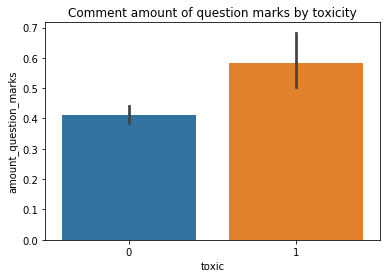

In [14]:
X['amount_question_marks']=nlp.amount_of_sign(train_test_text,'?')
inspect=pd.DataFrame(X['amount_question_marks']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="amount_question_marks", data=inspect, estimator=mean).set_title('Comment amount of question marks by toxicity')

Text(0.5, 1.0, 'Comment amount of question marks by obscenity')

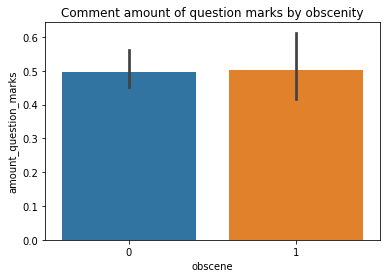

In [15]:
sns.barplot(x="obscene", y="amount_question_marks", data=inspect, estimator=mean).set_title('Comment amount of question marks by obscenity')

## Comment maximal question marks sequence
This feature's average values are different for toxic/non-toxic comments but for obscene/not-obscene the average values are similar.

Text(0.5, 1.0, 'Comment average maximal question marks sequence by toxicity')

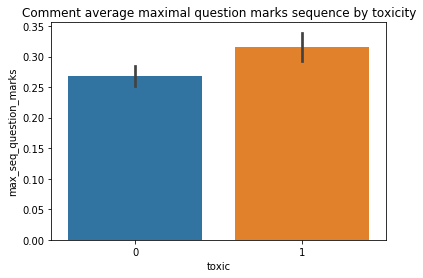

In [16]:
X['max_seq_question_marks']=nlp.max_sequence(train_test_text,'?')
inspect=pd.DataFrame(X['max_seq_question_marks']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="max_seq_question_marks", data=inspect, estimator=mean).set_title('Comment average maximal question marks sequence by toxicity')

Text(0.5, 1.0, 'Comment average maximal question marks sequence by obscenity')

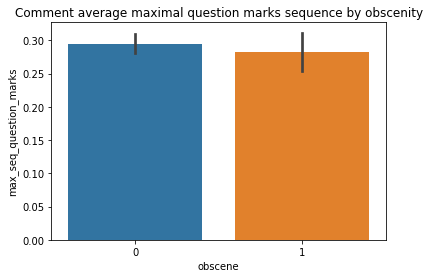

In [17]:
sns.barplot(x="obscene", y="max_seq_question_marks", data=inspect, estimator=mean).set_title('Comment average maximal question marks sequence by obscenity')

## Comment amount of exclamations
We can see that for both toxic and obscene comments, the amount of exclamations is much bigger.

Text(0.5, 1.0, 'Comment amount of exclamations by toxicity')

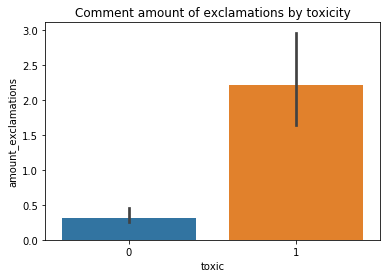

In [18]:
X['amount_exclamations']=nlp.amount_of_sign(train_test_text,'!')
inspect=pd.DataFrame(X['amount_exclamations']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="amount_exclamations", data=inspect, estimator=mean).set_title('Comment amount of exclamations by toxicity')

Text(0.5, 1.0, 'Comment amount of exclamations by obscenity')

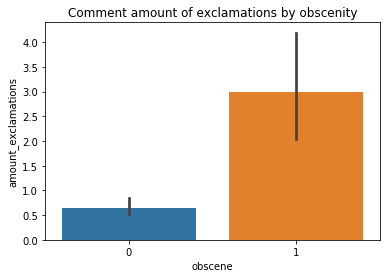

In [19]:
sns.barplot(x="obscene", y="amount_exclamations", data=inspect, estimator=mean).set_title('Comment amount of exclamations by obscenity')

## Comment maximal sequence of exclamations
It is clear to see that for toxic and obscene comments the maximal sequence of exclamations is higher.

Text(0.5, 1.0, 'Comment average maximal exclamations sequence by toxicity')

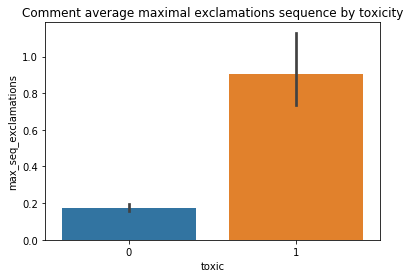

In [20]:
X['max_seq_exclamations']=nlp.max_sequence(train_test_text,'!')
inspect=pd.DataFrame(X['max_seq_exclamations']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="max_seq_exclamations", data=inspect, estimator=mean).set_title('Comment average maximal exclamations sequence by toxicity')

Text(0.5, 1.0, 'Comment average maximal exclamations sequence by obscenity')

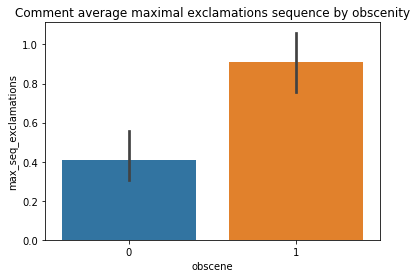

In [21]:
sns.barplot(x="obscene", y="max_seq_exclamations", data=inspect, estimator=mean).set_title('Comment average maximal exclamations sequence by obscenity')

## Comment amount of *
For both toxic and obscene comments, the average amount of stars is higher.

Text(0.5, 1.0, 'Comment amount of * by toxicity')

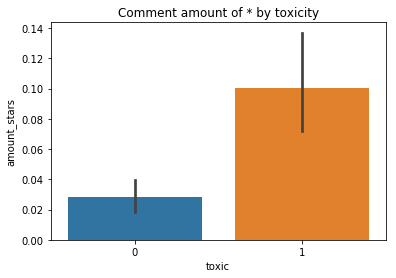

In [22]:
X['amount_stars']=nlp.amount_of_sign(train_test_text,'*')
inspect=pd.DataFrame(X['amount_stars']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="amount_stars", data=inspect, estimator=mean).set_title('Comment amount of * by toxicity')

Text(0.5, 1.0, 'Comment amount of * by obscenity')

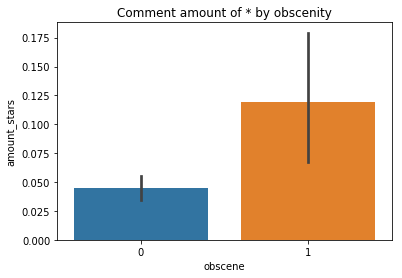

In [23]:
sns.barplot(x="obscene", y="amount_stars", data=inspect, estimator=mean).set_title('Comment amount of * by obscenity')

## Comment maximal sequence of *

For both toxic and obscene comments, the average maximal sequence of * is higher.

Text(0.5, 1.0, 'Comment average maximal sequence of *')

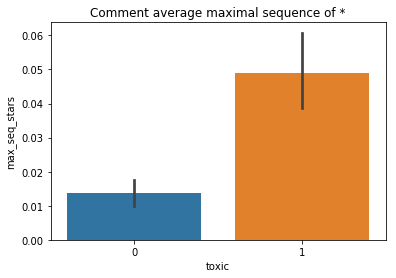

In [24]:
X['max_seq_stars']=nlp.max_sequence(train_test_text,'*')
inspect=pd.DataFrame(X['max_seq_stars']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="max_seq_stars", data=inspect, estimator=mean).set_title('Comment average maximal sequence of *')

Text(0.5, 1.0, 'Comment average maximal sequence of *')

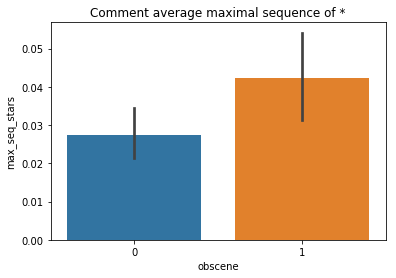

In [25]:
sns.barplot(x="obscene", y="max_seq_stars", data=inspect, estimator=mean).set_title('Comment average maximal sequence of *')

## Comment amount of dashes
Toxic and Obscene comments have less dashes.

Text(0.5, 1.0, 'Comment amount of dashes by toxicity')

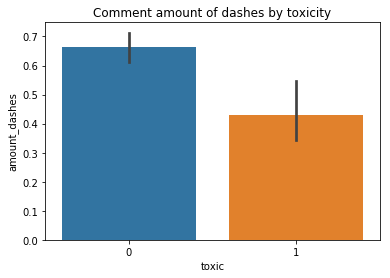

In [26]:
X['amount_dashes']=nlp.amount_of_sign(train_test_text,'-')
inspect=pd.DataFrame(X['amount_dashes']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="amount_dashes", data=inspect, estimator=mean).set_title('Comment amount of dashes by toxicity')

Text(0.5, 1.0, 'Comment amount of dashes by obscenity')

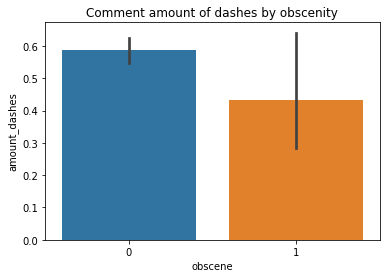

In [27]:
sns.barplot(x="obscene", y="amount_dashes", data=inspect, estimator=mean).set_title('Comment amount of dashes by obscenity')

## Comment maximal sequence of dashes
Toxic and obscene comments have shorter maximal sequence of dashes on average.

Text(0.5, 1.0, 'Comment average maximal sequence of dashes by toxicity')

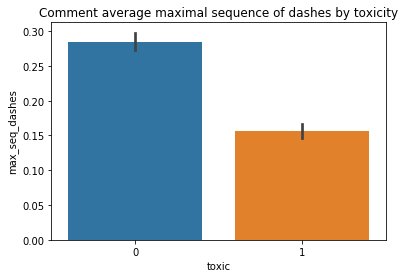

In [28]:
X['max_seq_dashes']=nlp.max_sequence(train_test_text,'-')
inspect=pd.DataFrame(X['max_seq_dashes']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="max_seq_dashes", data=inspect, estimator=mean).set_title('Comment average maximal sequence of dashes by toxicity')

Text(0.5, 1.0, 'Comment average maximal sequence of dashes by toxicity')

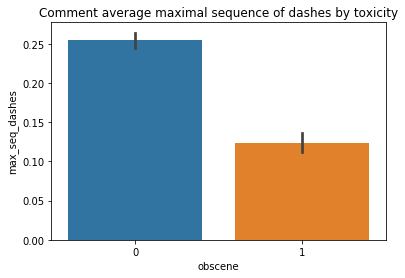

In [29]:
sns.barplot(x="obscene", y="max_seq_dashes", data=inspect, estimator=mean).set_title('Comment average maximal sequence of dashes by toxicity')

## Comment amount of equal sign
Toxic and obscene comments have more equal signs on average

Text(0.5, 1.0, 'Comment amount of equal sign by toxicity')

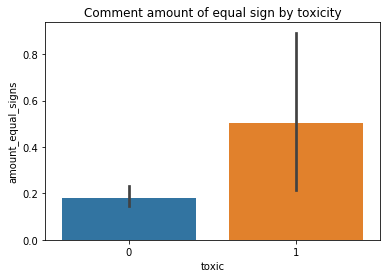

In [30]:
X['amount_equal_signs']=nlp.amount_of_sign(train_test_text,'=')
inspect=pd.DataFrame(X['amount_equal_signs']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="amount_equal_signs", data=inspect, estimator=mean).set_title('Comment amount of equal sign by toxicity')

Text(0.5, 1.0, 'Comment amount of equal sign by toxicity')

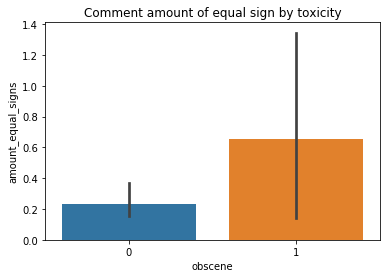

In [31]:
sns.barplot(x="obscene", y="amount_equal_signs", data=inspect, estimator=mean).set_title('Comment amount of equal sign by toxicity')

After I finished inspecting and counting all punctuation in the comments I am now removing it in order to proceed with the rest of the analysis.

In [32]:
train_test_text=nlp.remove_punctuation(train_test_text)

In this function I am performing a few more clean up procedures on the comments' text:
1. Turn all text to lower case. This is necessary for avoiding duplications in word processing.
2. Split all sentences to words for the rest of the analysis.
3. Remove ip addresses - Wikipedia comments tend to have ip addresses as words, I remove them using ReGex.
4. Remove comments with less than two words - these carry almost no information hence I will discard them.

In [33]:
train_test_text=nlp.clean_text_for_topic_modelling(train_test_text)

I remove the stopwords from the corpus since they contain no valuable information.

In [34]:
train_test_text=nlp.remove_stopwords_from_corpus(train_test_text)

Here I will be using one of two methods - either Lemmatization or Stemming. This is done for reducing words to their stem or lemmas in order to decrease the feature space and sparsity. Lemmatization is better but more computationally and time expensive therefore I will only use it in the final model.

In [35]:
# train_test_text=nlp.lemmatize_corpus(train_test_text)
train_test_text=nlp.stemm_corpus(train_test_text,stemmer='snowball')

I add bigrams of each comment. This technique helps add context to some of the words.

In [36]:
train_test_text=nlp.create_ngrams(train_test_text,num_grams=2)

I am using a list of profanity words I have found on https://github.com/RobertJGabriel/Google-profanity-words/blob/master/list.txt to identify swear words in each comment. I create two different features - the 'bin' one is binary and the 'agg' one is aggregating the amount of swear words

In [37]:
bad_words=pd.read_csv('bad_words.csv',names=['bad_words'])
bad_words=nlp.stemm_corpus(bad_words,stemmer='snowball')
# bad_words=nlp.lemmatize_corpus(bad_words)
bad_words=list(bad_words['bad_words'])
X['bad_words_bin']=nlp.bad_comments_column_bin(train_test_text,bad_words)
X['bad_words_agg']=nlp.bad_comments_column_agg(train_test_text,bad_words)

## Ratio of comments that inculde profanity
It is clear to see that both toxic and obscene comments have a higher ratio of profanity

Text(0.5, 1.0, 'Comment ratio of containing profanity by toxicity')

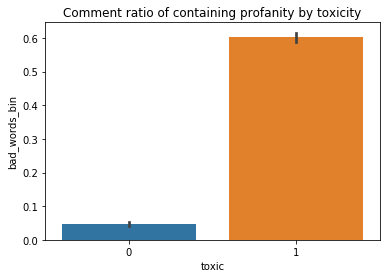

In [38]:
inspect=pd.DataFrame(X['bad_words_bin']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="bad_words_bin", data=inspect, estimator=mean).set_title('Comment ratio of containing profanity by toxicity')

Text(0.5, 1.0, 'Comment ratio of containing profanity by obscenity')

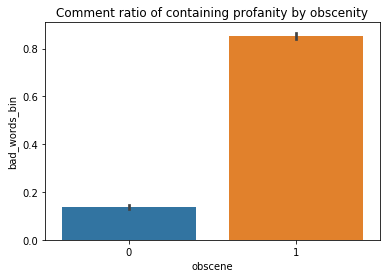

In [39]:
sns.barplot(x="obscene", y="bad_words_bin", data=inspect, estimator=mean).set_title('Comment ratio of containing profanity by obscenity')

## Amount of profanity
In this case we get the same results - toxic and obscene results have a higher amount of profanity

Text(0.5, 1.0, 'Comment amount of profanity by toxicty')

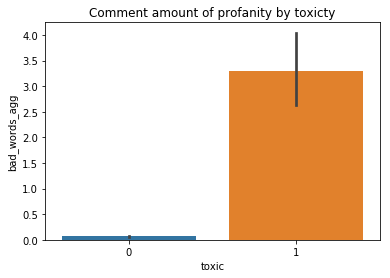

In [40]:
inspect=pd.DataFrame(X['bad_words_agg']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="bad_words_agg", data=inspect, estimator=mean).set_title('Comment amount of profanity by toxicty')

Text(0.5, 1.0, 'Comment amount of profanity by obscenity')

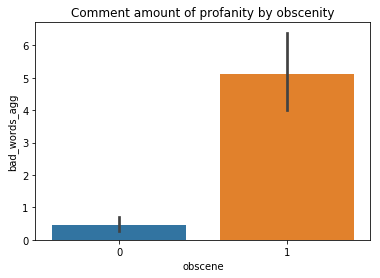

In [41]:
sns.barplot(x="obscene", y="bad_words_agg", data=inspect, estimator=mean).set_title('Comment amount of profanity by obscenity')

## Amount of positive words
I have used the list from https://gist.githubusercontent.com/mkulakowski2/4289437/raw/1bb4d7f9ee82150f339f09b5b1a0e6823d633958/positive-words.txt.
We can see that toxic and obscene comments have less positive words

In [42]:
positive_words=pd.read_csv('positive_words.csv',names=['positive_words'])
positive_words=nlp.stemm_corpus(positive_words,stemmer='snowball')
positive_words=list(positive_words['positive_words'])
X['positive_words_agg']=nlp.bad_comments_column_agg(train_test_text,positive_words)

Text(0.5, 1.0, 'Comment amount of positive words by toxicty')

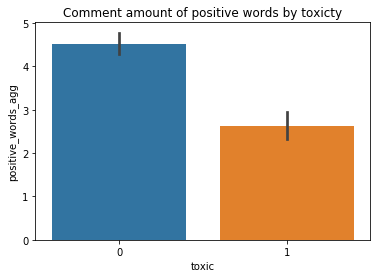

In [43]:
inspect=pd.DataFrame(X['positive_words_agg']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="positive_words_agg", data=inspect, estimator=mean).set_title('Comment amount of positive words by toxicty')

Text(0.5, 1.0, 'Comment amount of positive words by obscenity')

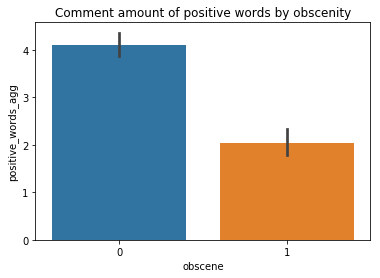

In [44]:
sns.barplot(x="obscene", y="positive_words_agg", data=inspect, estimator=mean).set_title('Comment amount of positive words by obscenity')

## Negative words
I have used the negative words list from https://gist.githubusercontent.com/mkulakowski2/4289437/raw/1bb4d7f9ee82150f339f09b5b1a0e6823d633958/negative-words.txt
Toxic and obscene comments have more negative words.

In [45]:
negative_words=pd.read_csv('negative_words.csv',names=['negative_words'])
negative_words=nlp.stemm_corpus(negative_words,stemmer='snowball')
negative_words=list(negative_words['negative_words'])
X['negative_words_agg']=nlp.bad_comments_column_agg(train_test_text,negative_words)

Text(0.5, 1.0, 'Comment amount of negative words by toxicty')

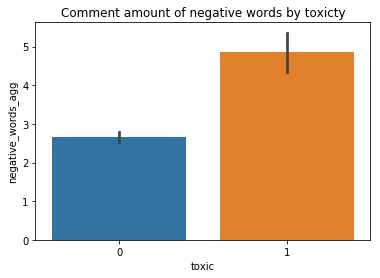

In [46]:
inspect=pd.DataFrame(X['negative_words_agg']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="toxic", y="negative_words_agg", data=inspect, estimator=mean).set_title('Comment amount of negative words by toxicty')

Text(0.5, 1.0, 'Comment amount of negative words by obscenity')

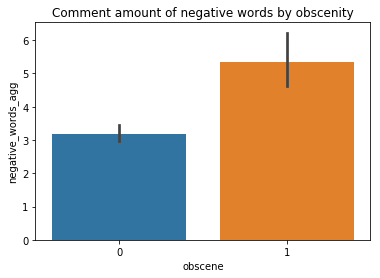

In [47]:
inspect=pd.DataFrame(X['negative_words_agg']).iloc[:10000].join(y_toxic).join(y_obscene)
sns.barplot(x="obscene", y="negative_words_agg", data=inspect, estimator=mean).set_title('Comment amount of negative words by obscenity')

## Gensim dictionary and filtering extremes
For the algorithms I am planning to use next, I will need to create a Gensim dictionary. This is a dictionary of all the words and bigrams I have in the corpus. I filter extreme word cases - if a word/bigram appears in less than 11 comments, this is not enough observations for the algorithm to make conclusions therefore I remove them. I also remove words that appear in more than 80% of the corpus since these also don't contain any unique information that will help classifying.

In [48]:
dic=nlp.gensim_dic(train_test_text,no_below=11,no_above=0.8)

## Tf-Idf algorithm
I use the Gensim dictionary to create a Tf-Idf table. This is short for term frequency–inverse document frequency. It is a table that holds a value for each word in each document. I chose this algorithm over other alternatives because it is very useful in classification problems. It considers the weight of the word realtive to both the specific document and to all of the corpus.

In [49]:
bow_corp=nlp.bow_corpus(dic,train_test_text)
tfidf=nlp.vec_to_tfidf(bow_corp)

##  Latent Dirichlet allocation
I use a topic modelling algorithm for assigning one of 20 topics to each comment. I suspect that some topics are more sensitive and therefore will have more toxic and obscene comments.

In [50]:
lda_model = nlp.lda_model(tfidf,dic)
X['lda_topic'] = nlp.assign_lda_topic(lda_model,bow_corp)

I turn the Tf-Idf object to matrix that can be appended to the features' matrix X.

In [51]:
tfidf_df=nlp.tf_idf_tomatrix(dic,tfidf)

## Scaling the data
Some of the algorithms I will be using require the feature space X to be standardized, so I use SKLearn's standard scaler for scaling X. I do this exculding the tfidf matrix which already has a different kind of standartization.

In [52]:
scaler = StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)

I join the tfidf table with the rest of the features and seperate it to train and test matrices.

In [53]:
X=X.join(tfidf_df)
X_train=X.iloc[:10000].copy()
X_test=X.iloc[10000:].copy()

I will now be trying out a few different Machine Learning algorithms for predicting the test set. I will be using cross validated F1 score estimates which is the metric used for evaluating performance in this specific competition.

## Logistic Regression
This is a classification algorithm which I found very useful because it allows to add a penalty to the function. I used the l1 penalty parameter(Lasso) because it allows for some coefficients of the model to be totally zeroed out. This is particularly useful for this kind of feature space because of it's huge size of predictors. Because we want to generalize our model, which is very complicated due to the number of features we would like to get rid of some of the features that are less useful or correlated with other features. This helps to lower the model's variance and improves the test score performance. I will use the CV results to pick the C tuning parameter which is tuning the regularization strength.

In [54]:
# Toxicity
CS=[0.1,2,3,4,5]
results=[]
for c in tqdm(CS):
    clf = LogisticRegression(penalty='l1',solver='liblinear',C=c)
    results.append((c,np.mean(cross_val_score(clf, X_train, y_toxic, cv=5, scoring='f1'))))
results_df=pd.DataFrame(results,columns=['c_value','cv_f1_score'])
results_df

 20%|████████████████▊                                                                   | 1/5 [00:12<00:48, 12.01s/it]C:\Users\natan\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\natan\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\natan\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 40%|█████████████████████████████████▌                                                  | 2/5 [03:25<03:19, 66.40s/it]C:\Users\natan\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of itera

c_value  cv_f1_score
0      0.1     0.799653
1      2.0     0.890622
2      3.0     0.890196
3      4.0     0.890552
4      5.0     0.888723

In [59]:
# Obscenity
CS=[0.5,2,3,3.5,4]
results=[]
for c in tqdm(CS):
    clf = LogisticRegression(penalty='l1',solver='liblinear',C=c)
    results.append((c,np.mean(cross_val_score(clf, X_train, y_obscene, cv=5, scoring='f1'))))
results_df=pd.DataFrame(results,columns=['c_value','cv_f1_score'])
results_df



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:14<00:59, 14.79s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:29<00:44, 14.68s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:43<00:29, 14.55s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:57<00:14, 14.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:12<00:00, 14.57s/it]



c_value  cv_f1_score
0      0.5     0.815253
1      2.0     0.816530
2      3.0     0.809713
3      3.5     0.806645
4      4.0     0.803279

## Random Forest Classifier
This classifer performs very well due to its ability to lower variance by creating many different uncorrelated decision trees. I will produce random values for some of the tuning parameters for getting the best CV F1 score. I chose a random grid search of the parameters because searching over all possible values can be very expensive computationally and time consuming. I chose the max depth of the trees to be no more than 75 because I don't want the tree to be too complicated and overfit the data. I chose a 150 trees to be the maximal amount of trees possible for calculation because any more than that will be computationally very expensive. I also chose the class_weight to be balanced due to the fact that for at least one of the target variables the classes are not even in size.

In [57]:
#toxicity
results=pd.DataFrame()
max_features_options=['auto',0.25,0.5,0.8]
for i in tqdm(range(1,6)):
    max_depth=randint(1, 75)
    n_estimators=randint(1, 150)
    max_features=randint(1, 4)
    rf = RandomForestClassifier(max_depth=max_depth, random_state=1,n_estimators=n_estimators,class_weight='balanced',
                                max_features=max_features_options[max_features-1])
    results.at[i,'cv_f1_score']=np.mean(cross_val_score(rf, X_train, y_toxic, cv=5, scoring='f1'))
    results.at[i,'max_depth']=max_depth
    results.at[i,'n_estimators']=n_estimators
    results.at[i,'max_features']=max_features_options[max_features-1]
results


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:29:17<00:00, 1339.10s/it]


cv_f1_score  max_depth  n_estimators max_features
1     0.859317       52.0          13.0         auto
2     0.871464       57.0          94.0         auto
3     0.867517       32.0          66.0          0.8
4     0.871954       64.0         143.0         auto
5     0.868448       33.0         119.0          0.8

In [60]:
#obscenity
results=pd.DataFrame()
max_features_options=['auto',0.25,0.5,0.8]
for i in tqdm(range(1,6)):
    max_depth=randint(1, 75)
    n_estimators=randint(1, 150)
    max_features=randint(1, 4)
    rf = RandomForestClassifier(max_depth=max_depth, random_state=1,n_estimators=n_estimators,class_weight='balanced',
                                max_features=max_features_options[max_features-1])
    results.at[i,'cv_f1_score']=np.mean(cross_val_score(rf, X_train, y_obscene, cv=5, scoring='f1'))
    results.at[i,'max_depth']=max_depth
    results.at[i,'n_estimators']=n_estimators
    results.at[i,'max_features']=max_features_options[max_features-1]
results



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████                                                                | 1/5 [20:58<1:23:55, 1258.89s/it]

 40%|█████████████████████████████████▏                                                 | 2/5 [27:08<49:36, 992.20s/it]

 60%|█████████████████████████████████████████████████▏                                | 3/5 [55:51<40:22, 1211.48s/it]

 80%|████████████████████████████████████████████████████████████████                | 4/5 [1:07:17<17:33, 1053.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:34:16<00:00, 1223.25s/it]



cv_f1_score  max_depth  n_estimators  max_features
1     0.814673       28.0         142.0          0.25
2     0.795929        6.0          49.0          0.80
3     0.811519       43.0          81.0          0.50
4     0.807868       41.0          46.0          0.50
5     0.804194       36.0          72.0          0.80

## Model selection and output
Logistic regression with l1 penalty and C=2 performed best for classifying both toxic and obscene comments. I will now use these parameters for predicting the test set.

In [61]:
clf = LogisticRegression(penalty='l1',solver='liblinear',C=2)

In [62]:
clf.fit(X_train, y_toxic)
toxic_results=clf.predict(X_test)

C:\Users\natan\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [63]:
clf.fit(X_train, y_obscene)
obscene_results=clf.predict(X_test)

In [64]:
try15=test.join(pd.DataFrame(toxic_results,columns=['toxic']))
try15=try15.join(pd.DataFrame(obscene_results,columns=['obscene']))
try15.drop('comment_text',1,inplace=True)

In [65]:
try15.to_csv('try15.csv',index=False)